In [1]:
# Run this cell to install DiffeRT and its dependencies, e.g., on Google Colab

try:
    import differt  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install differt[all]

(sampling-paths)=
# Sampling Path Candidates with Machine Learning

This notebook aims at being a tutorial to reproduce the results presented in the paper
**TODO**,
and assumes you are familiar with its content.

:::{important}
This notebook presents **version 2** of our work on the topic of *sampling path candidates*. You can access **v1**, as presented at the 2025 IEEE International Conference on Machine Learning for Communication and Networking (ICMLCN) in our paper *Towards Generative Ray Path Sampling for Faster Point-to-Point Ray Tracing* {cite}`sampling-icmlcn2025` [by clicking here](https://differt.rtfd.io/icmlcn2025/notebooks/sampling_paths.html).
:::

**You can run it locally or with Google Colab** by cliking on the rocket
at the top of this page!

:::{tip}
On Google Colab, make sure to select a GPU or TPU runtime for a faster experience.
:::

If you find this tutorial useful and plan on using this tool for your publications,
please cite our work, see {ref}`citing`.

:::{warning}
Training the models can take quite some time.

If you want to bypass the training and use a pre-trained model,
you can load the $K=1$ and $K=2$ models using
[`equinox.tree_deserialise_leaves`](https://docs.kidger.site/equinox/api/serialisation/),
and download the weights **TODO**.
:::

## Summary

In our work, we present a Machine Learning (ML) model that aims at reducing the computational complexity
of exhaustive Point-to-Point (P2P) Ray Tracing (RT) by learning how to sample path candidates.
For further details, please refer to the paper.

## Setup

Below are the importants steps to properly setup the environment.

### Imports

We need to import quite a few Python modules, but all of them should be installed with `pip install differt[all] treescope`. The following cell is hidden by default for readability.

In [10]:
from __future__ import annotations

import hashlib
from collections import defaultdict
from collections.abc import Iterable
from functools import partial
from itertools import islice, product
from pathlib import Path

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
import plotly.graph_objects as go
import treescope
from beartype import beartype as typechecker
from jaxtyping import (
    Array,
    Float,
    Int,
    PRNGKeyArray,
    PyTree,
    jaxtyped,
)
from tqdm.notebook import tqdm, trange

from differt.geometry import cartesian_to_spherical, normalize, orthogonal_basis
from differt.plotting import reuse, set_defaults
from differt.scene import (
    TriangleScene,
    download_sionna_scenes,
)
from sampling_paths import BASE_SCENE, Agent, random_scene, train_dataloader

# jax.config.update("jax_debug_nans", True)
# jax.config.update('jax_traceback_filtering', 'off')

### Pretty Printing

Nested structures, like Machine Learning modules, or more generaly PyTrees, do not render very nicely by default.
To provide the user with an interactive pretty-printing experience, we use `treescope`:

In [11]:
treescope.basic_interactive_setup(autovisualize_arrays=False)

### JAX Device

While this notebook will run fine all supported JAX devices (i.e., CPU, GPU, and TPU), using a GPU (or a TPU) will usually decrease the computational time by a significant factor.

To check the current active JAX device, use {func}`jax.devices`:

In [12]:
jax.devices()

[CpuDevice(id=0)]

## Generating the training data

For this tutorial, we restrict ourselves to a simple urban scenario, obtained from Sionna {cite}`sionna`,
from which we will derive random scenes.

In [13]:
download_sionna_scenes()  # Let's download Sionna scenes (from the main branch)

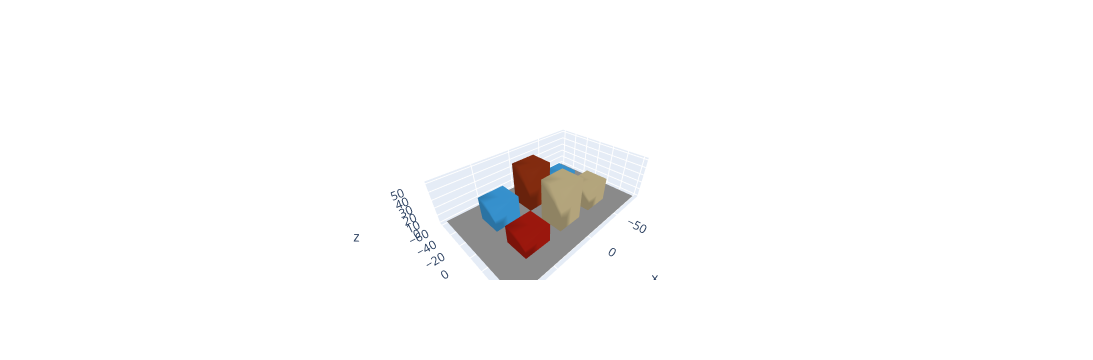

In [14]:
set_defaults(
    "plotly"
)  # Our scene is simple, and Plotly is the best backend for online interactive plots :-)

BASE_SCENE.plot()

From the `base_scene` object, we can generate random variations of it.
Two types of variations are considered here:

1. the number of objects (either triangles or quadrilaterals);
2. and the TX / RX positions.

As our model is invariant with respect to $\mathrm{SE}(3)$ and scaling, we *could* perform any scaling, translation, or rotation of the scene in the training dataset, without any impact on the model output, in theory[^1].

[^1]: In practice, we can observe slight differences in the output caused by floating point errors, leading to a different random sampling.

:::{note}
Unlike with NumPy and other common array libraries,
JAX requires an explicit random key ({func}`jr.key`) whenever you need to generate
pseudo-random numbers. While this can lead to more verbose code, this has the
**major advantage** of making random number generation easily reproducible,
even across multiple devices. *You want the same results? Then just pass the same key!*
:::

In [15]:
def stack_scenes(scenes: Iterable[TriangleScene]) -> TriangleScene:
    def stack(*elements: PyTree) -> PyTree:
        if eqx.is_array(elements[0]):
            return jnp.stack(elements)
        assert all(elements[0] == element for element in elements[1:])
        return elements[0]

    return jax.tree.map(stack, *scenes)


def get_num_stacked_scenes(scenes: TriangleScene) -> int:
    # This fails if scenes were not stacked properly
    batch, _, _ = scenes.mesh.triangles.shape
    return batch

Below, we demonstrate how to generate (and plot) a random scene.

Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 0) Found  1 valid paths our of    1 path candidates.


Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 1) Found  3 valid paths our of   62 path candidates.


Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 2) Found  4 valid paths our of 3782 path candidates.


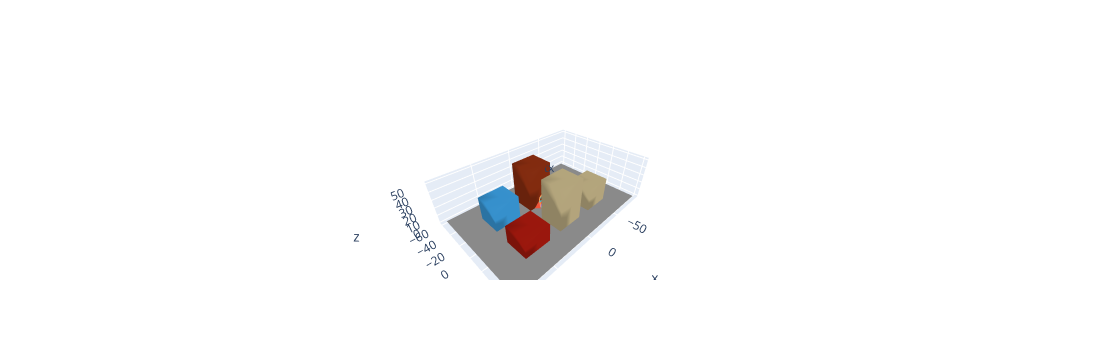

In [16]:
key_example = jr.key(1234)

with reuse() as fig:
    scene = random_scene(key=key_example)
    scene.plot(showlegend=False)

    num_active_primitives = scene.mesh.num_active_primitives

    for order in range(3):
        num_valid_paths = 0
        if order == 0:
            num_path_candidates = 1
        else:
            num_path_candidates = num_active_primitives * (
                num_active_primitives - 1
            ) ** (order - 1)
        for paths in tqdm(
            scene.compute_paths(order=order, chunk_size=1_000_000),
            desc="Processing path candidates",
            leave=False,
        ):
            num_valid_paths += paths.num_valid_paths
        paths.plot(showlegend=False)
        print(
            f"(order = {order}) Found {num_valid_paths:2d} valid paths our of {num_path_candidates:4d} path candidates."
        )

fig

We then collect some statistics about the scenes we are training on.

In [ ]:
key_stats = jr.key(1234)

scenes = train_dataloader(key=key_stats)

num_valid_paths = defaultdict(list)  # Number of valid paths
num_total_paths = defaultdict(list)  # Total number of path (candidates)

colors = {0: "black", 1: "blue", 2: "red", 3: "green"}

for _ in trange(
    1_000, desc="Collecting statistics over many realisations", leave=False
):
    scene = next(scenes)
    num_active_primitives = scene.mesh.num_active_primitives
    for order in colors:
        num_valid_paths[order].append(0)
        num_total_paths[order].append(0)
        for paths in scene.compute_paths(order=order, chunk_size=100_000):
            num_valid_paths[order][-1] += paths.mask.sum()
            num_total_paths[order][-1] += paths.mask.size

s = f" Scene '{scene_name}' "
print(f"{s:=^90}")
fig = go.Figure()
for order in colors:
    print(f"\tStatistics for {order = }:")
    num_valid = jnp.array(num_valid_paths[order])
    num_total = jnp.array(num_total_paths[order])
    avg_total = int(num_total.mean())
    frac = float((num_valid / num_total).mean())
    frac_one = float((num_valid > 0).sum() / num_valid.size)
    print(
        f"\t- an average of {avg_total} path candidates exist;\n"
        f"\t- out of which {100 * frac:.3f}% of the paths are valid\n"
        f"\t- and {100 * frac_one:.3f}% of the scenes contained at least one valid path."
    )
    fig.add_histogram(
        x=num_valid,
        histnorm="percent",
        name=f"{order = }",
        marker_color=colors[order],
    )

fig.update_layout(
    title="Distribution of the number of valid ray paths per scene",
    xaxis_title="Number of valid paths",
    yaxis_title="Percentage of scenes (%)",
)

## Reward function

Below, we define a reward function that simply checks
if a generated path candidate would produce a valid ray path.

The {attr}`Paths.mask<differt.geometry.Paths.mask>` attribute
is a boolean array where each entry indicates if the corresponding ray
path is valid or not. As we only have one pair of TX and RX, the sum
of all entries in this mask, when converted to floating point values,
is either 1 or 0.

### Differentiable reward

As {mod}`differt` is a differentiable library, thanks to JAX,
the reward function will be differentiable with respect to its arguments.

### Simulating non-differentiable reward

To observe what a non-differentiable reward would do, you can wrap the
return value of the reward function with
{func}`jax.lax.stop_gradient`, to effectively make the reward static.

We observed that a non-differentiable reward decreases the training performance,
leading to a lower accuracy and hit rate (see later) after the same number of steps.

In [ ]:
@eqx.filter_jit
def reward(
    path_candidates: Int[Array, "batch order"],
    scene: TriangleScene,
    *,
    non_differentiable: bool = False,
) -> Float[Array, " batch"]:
    """
    Reward predicted path candidates depending on whether it
    produces a valid path in the given scene.

    Args:
        path_candidates: The path candidates to evaluate.
        scene: The scene on which to evaluate the path candidates.
        non_differentiable: Whether to stop gradients.

    Returns:
        A reward of 0 or 1 for each path candidate.
    """
    r = scene.compute_paths(path_candidates=path_candidates).mask.astype(float)
    if non_differentiable:
        return jax.lax.stop_gradient(r)

    return r

## Machine Learning model

Our model is made of two parts: an inner flow model, that returns the flows between a parent state and its child states,
and an outer model, that extracts features from the scene, and repeatedly calls the Flow model to generate a path candidate.

:::{note}
While the model below accepts arbitrarily many TXs or RXs,
it only makes sense to train it on a single TX and a single RX at a time,
as different positions usually lead to different path candidates being valid.
:::

### From triangle vertices to feature vectors

This model maps the scene objects into feature vectors, while making sure that:

1. any permutation in the objects ordering results in the same exact permutation of the output vectors;
2. and the output is invariant with respect to any translation, scaling, or rotation operation applied on the scene.

In [ ]:
class SceneEncoder(eqx.Module):
    """Generate embeddings from triangle vertices."""

    mlp: eqx.nn.MLP

    def __init__(
        self,
        num_embeddings: int,
        width_size: int,
        depth: int,
        *,
        key: PRNGKeyArray,
    ) -> None:
        self.mlp = eqx.nn.MLP(
            3 * 3,
            out_size=num_embeddings,
            width_size=width_size,
            depth=depth,
            key=key,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        scene: TriangleScene,
    ) -> Float[Array, "num_triangles num_embeddings"]:
        rx = scene.transmitters.reshape(3)
        tx = scene.receivers.reshape(3)
        triangle_vertices = scene.mesh.triangle_vertices
        u, scale = normalize(rx - tx, keepdims=True)
        v, w = orthogonal_basis(u)
        basis = jnp.stack((v, w, u))  # tx->rx is the new 'z' direction
        triangle_vertices = (
            scene.mesh.translate(-tx)
            .scale(1 / scale)
            .rotate(basis)
            .triangle_vertices
        )
        xyz = triangle_vertices.reshape(-1, 9)
        return jax.vmap(self.mlp)(xyz)

        rpa = cartesian_to_spherical(xyz)
        # azimuth angle is equivariant with a rotation around the tx->rx axis
        # so we must transform it into a equivariant feature
        da = jnp.subtract.outer(rpa[:, 2], rpa[:, 2])
        two_pi = 2 * jnp.pi
        da = (da + two_pi) % two_pi
        sda = jnp.sum(da, axis=-1)
        rpa = rpa.at[:, 2].set(sda)
        return jax.vmap(self.mlp)(rpa.reshape(-1, 9))


class StateEncoder(eqx.Module):
    """Generate embeddings for a (partial) path candidates."""

    linear: eqx.nn.Linear

    def __init__(
        self,
        order: int,
        num_embeddings: int,
        *,
        key: PRNGKeyArray,
    ) -> None:
        self.linear = eqx.nn.Linear(
            in_features=num_embeddings * order,
            out_features=num_embeddings,
            use_bias=False,
            key=key,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self, path_candidate_object_embeds: Float[Array, "order num_embeddings"]
    ) -> Float[Array, num_embeddings]:
        return self.linear(path_candidate_object_embeds.reshape(-1))

### From features to flows

The second part of our model maps, for each input object,
three feature vectors into a vector of flows:

1. the feature vector of the scene;
2. the feature vector of the object;
3. and the current state vectors, constructed from the feature vector of objects that were selected in previous states.

In [ ]:
class Flow(eqx.Module):
    dropout_rate: float
    inference: bool

    scene_encoder: SceneEncoder
    state_encoder: StateEncoder

    head: eqx.nn.MLP

    def __init__(
        self,
        *,
        order: int,
        num_embeddings: int,
        width_size: int,
        depth: int,
        dropout_rate: int = 0.05,
        inference: bool = False,
        key: PRNGKeyArray,
    ) -> None:
        scene_enc_key, state_enc_key, head_key = jr.split(key, 3)
        self.scene_encoder = SceneEncoder(
            num_embeddings=num_embeddings,
            width_size=width_size,
            depth=depth,
            key=scene_enc_key,
        )
        self.state_encoder = StateEncoder(
            order=order,
            num_embeddings=num_embeddings,
            key=state_enc_key,
        )
        self.head = eqx.nn.MLP(
            in_size=num_embeddings * (order + 1),
            out_size="scalar",
            width_size=num_embeddings,
            activation=jax.nn.leaky_relu,
            depth=depth,
            key=head_key,
        )
        self.dropout_rate = dropout_rate
        self.inference = inference

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        scene: TriangleScene,
        partial_path_candidate: Int[Array, " order"],
        *,
        inference: bool | None = None,
        key: PRNGKeyArray | None = None,
    ) -> Float[Array, num_objects]:
        # We work with log of probabilities, so exp(-100) ~= 0
        stopped_flow = -100.0
        object_embeds = self.scene_encoder(scene)
        pc_object_embeds = jnp.take(
            object_embeds, partial_path_candidate, axis=0, fill_value=0
        )
        pc_embeds = pc_object_embeds.reshape(-1)
        # pc_embeds = self.state_encoder(pc_object_embeds)
        pc_embeds = jnp.tile(pc_embeds, (object_embeds.shape[0], 1))

        flows = jax.vmap(self.head)(
            jnp.concat((object_embeds, pc_embeds), axis=1)
        )

        if scene.mesh.mask is not None:
            flows = jnp.where(scene.mesh.mask, flows, stopped_flow)

        # Stop flow from flowing to the same object twice in a row
        i = jnp.argwhere(
            partial_path_candidate == -1, size=1, fill_value=-1
        ).reshape(())
        last_object = partial_path_candidate.at[i - 1].get(
            wrap_negative_indices=False, fill_value=-1
        )
        flows = flows.at[last_object].set(
            stopped_flow, wrap_negative_indices=False
        )

        if inference is None:
            inference = self.inference
        if inference:
            return flows
        if key is None:
            raise ValueError(
                "Argument 'key' cannot be 'None' when not running in inference mode."
            )
        # flows = jnp.exp(flows)

        q = 1 - jax.lax.stop_gradient(self.dropout_rate)
        mask = jr.bernoulli(key, q, flows.shape)
        return jnp.where(mask, flows, stopped_flow)

## Learning

In the trajectory balance equation, $Z$ represents the sum of 

# Learning the number of valid paths

In the trajectory balance equation, $Z$ represents the sum of all possible rewards. In our context, this value changes with the input scene.

Instead of learning a fixed value for $Z$, we will train a model to predict its value based on the input scene.

In [ ]:
class Z(eqx.Module):
    scene_encoder: SceneEncoder
    phi: eqx.nn.Linear
    alpha: eqx.nn.Linear
    rho: eqx.nn.Linear

    def __init__(
        self,
        num_embeddings: int,
        width_size: int,
        depth: int,
        *,
        key: PRNGKeyArray,
    ) -> None:
        scene_enc_key, phi_key, alpha_key, rho_key = jr.split(key, 4)
        self.scene_encoder = SceneEncoder(
            num_embeddings=num_embeddings,
            width_size=width_size,
            depth=depth,
            key=scene_enc_key,
        )
        self.phi = eqx.nn.Linear(
            in_features=num_embeddings,
            out_features=num_embeddings,
            key=phi_key,
        )
        self.alpha = eqx.nn.Linear(
            in_features=num_embeddings,
            out_features="scalar",
            key=alpha_key,
        )
        self.rho = eqx.nn.Linear(
            in_features=num_embeddings,
            out_features="scalar",
            key=rho_key,
        )

    def __call__(self, scene: TriangleScene) -> Float[Array, " "]:
        x = self.scene_encoder(scene)
        x_phi = jax.vmap(self.phi)(x)
        x_alpha = jax.nn.softmax(jax.vmap(self.alpha)(x))
        out = self.rho((x_alpha[:, None] * x_phi).sum(axis=0))
        # Clip output to positive values only
        # because it makes no sense to predict a negative
        # number of valid paths
        return jax.nn.relu(out)

In [ ]:
class Memory(eqx.Module):
    """Memory to hold 'experiences' about sampled path candidates.

    This serves two purposes:
    1. Allowing to compute averaged reward over multiple samples;
    2. Replaying past experiences to learn other goals,
       like the estimated number of valid paths on a given scene.
    """

    memory_size: int = eqx.field(static=True)

    scene_keys: Key[Array, " memory_size"]
    # We don't store scenes, but rather keys that we can use to re-generate a scene.
    path_candidates: Int[Array, "memory_size order"]
    rewards: Float[Array, " memory_size"]
    counter: Int[Array, " "]

    def __init__(self, memory_size: int, order: int, key_dtype: type) -> None:
        self.memory_size = memory_size

        self.scene_keys = jnp.empty((memory_size,), dtype=key_dtype)
        self.path_candidates = -jnp.ones((memory_size, order), dtype=int)
        self.rewards = jnp.empty((memory_size,))

        self.counter = jnp.array(0)

    @eqx.filter_jit
    def add_experiences(
        self,
        scene_keys: Key[Array, " batch_size"],
        path_candidates: Int[Array, "batch_size trajectory_length"],
        rewards: Float[Array, " batch_size"],
    ) -> Self:
        batch_size = scene_keys.shape[0]
        indices = (self.counter + jnp.arange(batch_size)) % self.memory_size
        return eqx.tree_at(
            lambda mem: (
                mem.scene_keys,
                mem.path_candidates,
                mem.rewards,
                mem.counter,
            ),
            self,
            (
                self.scene_keys.at[indices].set(
                    scene_keys, wrap_negative_indices=False
                ),
                self.path_candidates.at[indices].set(
                    path_candidates, wrap_negative_indices=False
                ),
                self.rewards.at[indices].set(
                    rewards, wrap_negative_indices=False
                ),
                self.counter + batch_size,
            ),
        )

    @eqx.filter_jit
    def average_reward(self) -> Float[Array, " "]:
        return jnp.mean(
            self.rewards, where=(self.path_candidates != -1).all(axis=-1)
        )

    @eqx.filter_jit
    def average_num_valid_path_candidates_per_data_key(
        self,
    ) -> Float[Array, " "]:
        keys = jr.key_data(self.scene_keys)
        traj = self.path_candidates
        rews = self.rewards
        # Sort by data key and then by trajectory
        idx = jnp.lexsort((*keys.T, *traj.T)[::-1])
        keys = keys[idx]
        traj = traj[idx]
        rews = rews[idx]
        # True each time the key changes
        key_changes = jnp.concat((
            jnp.array([True]),
            (jnp.diff(keys, axis=0) != 0).all(axis=1),
        ))
        key_changes.sum()
        # True each time the trajectory changes
        traj_changes = jnp.concat((
            jnp.array([True]),
            (jnp.diff(traj, axis=0) != 0).all(axis=1),
        ))
        traj_changes |= key_changes  # New key means new traj
        traj_changes &= rews > 0  # We only count valid path_candidates

        return traj_changes.sum() / key_changes.sum()

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def sample_experiences(
        self, batch_size: int, *, key: PRNGKeyArray
    ) -> tuple[
        Key[Array, " batch_size"],
        Int[Array, "batch_size trajectory_length"],
        Float[Array, " batch_size"],
    ]:
        # JIT-friendly way of sampling indices up to min(counter, memory_size)
        indices = jnp.arange(self.memory_size)
        p = jnp.where(self.rewards[indices] > 0, 10.0, 1.0)
        p = jnp.where(indices >= self.counter, 0.0, p)
        indices = jr.choice(key, indices, (batch_size,), replace=False, p=p)
        return (
            self.scene_keys[indices],
            self.path_candidates[indices],
            self.rewards[indices],
            self.goal_path_candidates[indices],
        )

### Everything put together

Then, we can construct our model to generate a path candidate from a given scene configuration
and a random key, building on the two previous classes we defined.

In [ ]:
class Model(eqx.Module):
    order: int = eqx.field(static=True)

    shared: eqx.nn.Shared

    def __init__(
        self,
        *,
        order: int,
        num_embeddings: int,
        width_size: int,
        depth: int,
        key: PRNGKeyArray,
    ) -> None:
        self.order = order

        flow_key, z_key = jr.split(key)
        flow = Flow(
            order=order,
            num_embeddings=num_embeddings,
            width_size=width_size,
            depth=depth,
            key=flow_key,
        )
        z = Z(
            num_embeddings=num_embeddings,
            width_size=width_size,
            depth=depth,
            key=z_key,
        )

        # Explicitly share the scene encoder
        where = lambda flow_and_z: flow_and_z[1].scene_encoder
        get = lambda flow_and_z: flow_and_z[0].scene_encoder
        self.shared = eqx.nn.Shared((flow, z), where, get)

    @property
    def flow(self) -> Flow:
        return self.shared()[0]

    @property
    def Z(self) -> Flow:
        return self.shared()[1]

    @eqx.filter_jit
    def __call__(
        self,
        scene: TriangleScene,
        *,
        inference: bool | None = None,
        key: PRNGKeyArray,
    ) -> Int[Array, " order"]:
        partial_path_candidate = -jnp.ones(self.order, dtype=int)
        parent_flow_key, key = jr.split(key)
        parent_flows = self.flow(
            scene,
            partial_path_candidate,
            key=parent_flow_key,
        )

        for i, key in enumerate(jr.split(key, self.order)):
            edge_flow_key, action_key = jr.split(key)

            logits = parent_flows
            action = jr.categorical(action_key, logits=logits)
            partial_path_candidate = partial_path_candidate.at[i].set(action)

            edge_flows = self.flow(
                scene,
                partial_path_candidate,
                inference=inference,
                key=edge_flow_key,
            )

            parent_flows = edge_flows

        path_candidate = partial_path_candidate
        return path_candidate


class Agent(eqx.Module):
    # Static
    order: int = eqx.field(static=True)
    batch_size: int = eqx.field(static=True)
    augmented: bool = eqx.field(static=True)

    # Trainable
    model: Model

    # Updatable
    memory: Memory
    optim: optax.GradientTransformationExtraArgs
    opt_state: optax.OptState
    steps_count: Int[Array, " "]

    def __init__(
        self,
        *,
        order: int,
        num_embeddings: int = 128,
        width_size: int = 256,
        depth: int = 3,
        batch_size: int = 64,
        optim: optax.GradientTransformationExtraArgs | None = None,
        augmented: bool = False,
        memory_size: int = 10_000,
        key: PRNGKeyArray,
    ) -> None:
        self.order = order
        self.batch_size = batch_size
        self.augmented = augmented

        assert not augmented

        self.model = Model(
            order=order,
            num_embeddings=num_embeddings,
            width_size=width_size,
            depth=depth,
            key=key,
        )

        self.memory = Memory(
            order=order, memory_size=memory_size, key_dtype=key.dtype
        )
        self.optim = optax.adam(3e-5) if optim is None else optim
        self.opt_state = self.optim.init(eqx.filter(self.model, eqx.is_array))
        self.steps_count = jnp.array(0)

    @eqx.filter_jit
    def train_flow_model(
        self, *, key: PRNGKeyArray
    ) -> tuple[Self, Float[Array, " "]]:
        def loss(
            model: Model, key: PRNGKeyArray
        ) -> tuple[
            Float[Array, " "], tuple[Int[Array, " order"], Float[Array, " "]]
        ]:
            partial_path_candidate = -jnp.ones(self.order, dtype=int)
            parent_flow_key, key = jr.split(key)
            parent_flows = model.flow(
                scene,
                partial_path_candidate,
                key=parent_flow_key,
            )

            # Sums of forward and backward flows (policies)
            sum_log_P_F = 0.0
            sum_log_P_B = 0.0
            flow_mismatch = 0.0

            for i, key in enumerate(jr.split(key, self.order)):
                edge_flow_key, action_key = jr.split(key)

                logits = parent_flows
                action = jr.categorical(action_key, logits=logits)
                partial_path_candidate = partial_path_candidate.at[i].set(
                    action
                )

                sum_log_P_F += jax.nn.log_softmax(logits)[action]

                # jax.debug.print("Action = {a}", a=action)

                edge_flows = model.flow(
                    scene, partial_path_candidate, key=edge_flow_key
                )

                if i == (self.order - 1):
                    sum_edge_flows = reward(
                        partial_path_candidate.reshape(1, -1), scene
                    ).reshape(())
                else:
                    sum_edge_flows = edge_flows.sum()

                flow_mismatch += (parent_flows[action] - sum_edge_flows) ** 2

                sum_log_P_B += jnp.log(1)

                parent_flows = edge_flows

            path_candidate = partial_path_candidate
            R = reward(path_candidate.reshape(1, -1), scene).reshape(())
            log_R = jnp.log(R).clip(min=-100.0)
            log_Z = jnp.log(model.Z(scene)).clip(min=-100.0)

            tb_loss = (log_Z + sum_log_P_F - log_R - sum_log_P_B) ** 2

            return tb_loss, (path_candidate, R)

        def batch_loss(
            model: Model,
            keys: Key[Array, " batch_size"],
        ) -> tuple[
            Float[Array, " "],
            tuple[Int[Array, "batch_size order"], Float[Array, " batch_size"]],
        ]:
            tb_losses, aux = jax.vmap(loss, in_axes=(None, 0))(model, keys)
            return tb_losses.mean(), aux

        scene_key, batch_loss_key = jr.split(key)
        scene = random_scene(key=scene_key)

        (losses, (path_candidates, rewards)), grads = eqx.filter_value_and_grad(
            batch_loss, has_aux=True
        )(self.model, jr.split(batch_loss_key, self.batch_size))

        scene_keys = jnp.repeat(scene_key, self.batch_size)

        mem = self.memory.add_experiences(
            scene_keys,
            path_candidates,
            rewards,
        )

        updates, opt_state = self.optim.update(
            grads, self.opt_state, eqx.filter(self.model, eqx.is_array)
        )

        return (
            eqx.tree_at(
                lambda agent: (
                    agent.model,
                    agent.opt_state,
                    agent.memory,
                    agent.steps_count,
                ),
                self,
                (
                    eqx.apply_updates(self.model, updates),
                    opt_state,
                    mem,
                    self.steps_count + 1,
                ),
            ),
            losses.mean(),
        )

    @eqx.filter_jit
    def train_Z_model(
        self, *, key: PRNGKeyArray
    ) -> tuple[Self, Float[Array, " "]]:
        def loss(model: Model, key: PRNGKeyArray) -> Float[Array, " "]:
            scene = random_scene(key=key)
            num_valid_paths = scene.compute_paths(order=order).mask.sum()
            Z = model.Z(scene)
            delta = Z - num_valid_paths
            # We penalize more if the model under-estimates
            return jnp.where(delta > 0, delta, -10 * delta)

        def batch_loss(
            model: Model,
            keys: Key[Array, " batch_size"],
        ) -> Float[Array, " "]:
            return jax.vmap(loss, in_axes=(None, 0))(model, keys).mean()

        losses, grads = eqx.filter_value_and_grad(batch_loss)(
            self.model, jr.split(key, self.batch_size)
        )

        updates, opt_state = self.optim.update(
            grads, self.opt_state, eqx.filter(self.model, eqx.is_array)
        )

        return (
            eqx.tree_at(
                lambda agent: (
                    agent.model,
                    agent.opt_state,
                ),
                self,
                (
                    eqx.apply_updates(self.model, updates),
                    opt_state,
                ),
            ),
            losses.mean(),
        )

### Loss function

Essential to any ML task, the loss function is what is used to compute gradient updates in the training process.

We define our loss function to closely follows that of *GFlowNet* models: the goal
is to have a matching between a giving parent flow at a state $s$ and the sum of the flows of all
its child states $s'$, where the last child state is replaced by the reward of the corresponding path candidate.

All the mathematical details are available in the paper.

### Accuracy and hit rate

The loss does not always carry meaningful information to the user about how the model performs.

Here, we define another utility function that evaluates the model on a validation dataset,

In [ ]:
@partial(eqx.filter_jit, inline=True)
def accuracy(
    scene: TriangleScene,
    path_candidates: Int[Array, "num_path_candidates order"],
) -> Float[Array, " "]:
    paths = scene.compute_paths(path_candidates=path_candidates)
    num_valid_paths = paths.mask.astype(jnp.float32).sum()
    return num_valid_paths / path_candidates.shape[0]


@partial(eqx.filter_jit, inline=True)
def hit_rate(
    scene: TriangleScene,
    path_candidates: Int[Array, "num_path_candidates order"],
) -> Float[Array, " "]:
    _, order = path_candidates.shape
    paths = scene.compute_paths(path_candidates=path_candidates)
    num_paths_found = (
        paths.mask_duplicate_objects().mask.astype(jnp.float32).sum()
    )
    num_paths_total = (
        scene.compute_paths(order=order).mask.astype(jnp.float32).sum()
    )
    return num_paths_found / num_paths_total


@eqx.filter_jit
def evaluate(
    model: Model,
    scenes: TriangleScene,
    num_path_candidates: int = 1,
    *,
    key: PRNGKeyArray,
) -> tuple[Float[Array, " "], Float[Array, " "]]:
    """
    Evaluate the model accuracy and hit rate on a sequence of scenes.

    The accuracy is simply the total number of valid paths generated,
    divided by the number of path candidates generated.

    The hit rate is the ratio of valid path founds divided by the total number of
    valid paths that exist.

    Args:
        model: The model to evaluate.
        scenes: The (stacked) scenes on which to evaluate the model.
        num_path_candidates: The number of path candidates that will be
            generated to compute the accuracy.
        key: The random key to be used.

    Returns:
        The average accuracy and average hit rate.
    """
    scenes, static = eqx.partition(scenes, eqx.is_array)

    def _evaluate(
        scene: TriangleScene, key: PRNGKeyArray
    ) -> tuple[Float[Array, " "], Float[Array, " "]]:
        scene = eqx.combine(scene, static)
        path_candidates = jax.vmap(
            lambda key: model(scene, inference=True, key=key)
        )(jr.split(key, num_path_candidates))
        return accuracy(scene, path_candidates), hit_rate(
            scene, path_candidates
        )

    n = get_num_stacked_scenes(scenes)
    keys = jr.split(key, n)

    accuracies, hit_rates = jax.vmap(_evaluate)(scenes, keys)

    return accuracies.mean(), hit_rates.mean()

## Training

For training, we rely on the `optax` module that provides
convenient optimizers, from which we use the popular {func}`optax.adam` optimizer.

Every few training steps, we will evaluate the model's performance to obtain the curves presented in the paper.

In [ ]:
order = 1
num_embeddings = 32
batch_size = 64

key = jr.key(1234)
key_agent, key_episodes, key_valid_samples = jr.split(key, 3)
valid_samples = train_dataloader(key=key_valid_samples)
valid_samples = filter(
    lambda scene: scene.compute_paths(order=order).mask.any(), valid_samples
)
valid_samples = [
    next(valid_samples)
    for _ in trange(100, desc="Generating validation samples")
]
valid_scenes = stack_scenes(valid_samples)

agent = Agent(
    order=order,
    num_embeddings=num_embeddings,
    batch_size=batch_size,
    augmented=False,
    key=key_agent,
)

# TODO: remove state-based reward, and only add a decreasing edge-based one

num_episodes = 500_000

progress_bar = tqdm(jr.split(key_episodes, num_episodes))
print_every = 100

episodes = []
success_rates = []
num_trajs = []
success_rates_val = []
hit_rates_val = []
z_losses = []
# Z = []

for episode, key_episode in enumerate(progress_bar):
    # Perform an optimization based on the flow-matching rule
    # using the unconditional model
    # This will populate the memory with experiences
    train_flow_key, train_Z_key, eval_key = jr.split(key_episode, 3)
    agent, z_loss = agent.train_Z_model(key=train_Z_key)
    agent, flow_loss = agent.train_flow_model(key=train_flow_key)

    if episode % print_every == 0:
        progress_bar.set_description(f"(Z model) loss: {z_loss:.5f}")
        z_losses.append(z_loss)
        success_rate = 100 * agent.memory.average_reward()
        avg_num_traj_found = (
            agent.memory.average_num_valid_path_candidates_per_data_key()
        )

        acc, hit_r = evaluate(agent.model, valid_scenes, key=eval_key)

        progress_bar.set_description(
            f"(memory) success rate: {success_rate:.5f}%, (valid.): success rate {100 * acc:.5f}, hit rate {100 * hit_r:.5f}, (Z model) loss: {z_loss:.5f}"
        )

        # episodes.append(episode)
        # success_rates.append(success_rate)
        # success_rates_val.append(100*acc)
        # hit_rates_val.append(100*hit_r)
        # num_trajs.append(avg_num_traj_found)
        # Z.append(jnp.exp(agent.flow.log_Z))


agent

In [ ]:
plt.figure()
plt.title(f"Sampling in canyon only (K = {order})")
plt.plot(episodes, success_rates, "--", label="Acc. (%) - Train")
plt.plot(episodes, success_rates_val, "--", label="Acc. (%) - Valid")
plt.plot(episodes, hit_rates_val, "--", label="Hit-rate (%) - Valid")
plt.xlabel("Episodes")
plt.ylabel("Acc. / Hit rate (%)")
plt.legend()
plt.twinx()
plt.plot(episodes, num_trajs, "k--")
plt.ylabel("Avg. number of valid paths found")
plt.axhline(jnp.array(num_valid_paths[order]).mean(), color="k")
plt.savefig(f"whole_{order}.png")

### $K=1$ - Single reflection

Let's first train a model to generate single-bounce reflection path candidates.

In [ ]:
key_train = jr.key(1234)
key_model, key_train_model, key_train_samples = jr.split(key_train, 3)

order = 1
optim = optax.adam(learning_rate=1e-5)

untrained_model = Model(num_features=512, dropout_rate=0.25, key=key_model)
train_samples = train_dataloader(base_scene, key=key_train_samples)

untrained_model

In [ ]:
key_valid_samples = jr.key(1234)
valid_samples = train_dataloader(base_scene, key=key_valid_samples)
valid_samples = filter(
    lambda scene: scene.compute_paths(order=order).mask.any(), valid_samples
)
valid_samples = tuple(
    next(valid_samples)
    for _ in trange(100, desc="Generating validation samples")
)

In [ ]:
trained_model, train_losses, train_accuracies, train_hit_rates = train(
    untrained_model,
    train_samples,
    valid_samples,
    optim,
    order=order,
    key=key_train_model,
    batch=10,
    loss_params={"num_path_candidates": 50},
)
trained_model

In [ ]:
# Save data

eqx.tree_serialise_leaves("model.eqx", trained_model)
jnp.save("train_losses.npy", train_losses)
jnp.save("train_accuracies.npy", train_accuracies)
jnp.save("train_hit_rates.npy", train_hit_rates)

# Plot results

steps = jnp.linspace(0, len(train_losses), len(train_accuracies))

fig, ax1 = plt.subplots()

ax1.set_xlabel("Train steps")
ax1.set_ylabel("Accuracy (%)")
ax1.plot(steps, 100 * train_accuracies)

ax2 = ax1.twinx()
ax2.set_ylabel("Hit rate (%)")
ax2.plot(steps, 100 * train_hit_rates, "k--")

fig.tight_layout();

In [ ]:
order = 2
optim = optax.adam(learning_rate=1e-5)

key_valid_samples = jr.key(1234)
valid_samples = train_dataloader(base_scene, key=key_valid_samples)
valid_samples = filter(
    lambda scene: scene.compute_paths(order=order).mask.any(), valid_samples
)
valid_samples = tuple(
    next(valid_samples)
    for _ in trange(100, desc="Generating validation samples")
)

In [ ]:
# optim = optax.adamw(1e-4)
# optim = optax.adam(learning_rate=1e-4)
# untrained_model = Model(num_features=128, dropout_rate=0.0, key=key_model)
trained_model_2, train_losses_2, train_accuracies_2, train_hit_rates_2 = train(
    trained_model,  # We start from previous model
    train_samples,
    valid_samples,
    optim,
    order=order,
    key=key_train_model,
    batch=20,
    loss_params={"num_path_candidates": 100},
    steps=10_000,
)
trained_model_2

In [ ]:
eqx.tree_serialise_leaves("model_2.eqx", trained_model_2)
jnp.save("train_losses_2.npy", train_losses_2)
jnp.save("train_accuracies_2.npy", train_accuracies_2)
jnp.save("train_hit_rates_2.npy", train_hit_rates_2)

steps = jnp.linspace(0, len(train_losses_2), len(train_accuracies_2))

fig, ax1 = plt.subplots()

ax1.set_xlabel("Train steps")
ax1.set_ylabel("Accuracy (%)")
ax1.plot(steps, 100 * train_accuracies_2)

ax2 = ax1.twinx()
ax2.set_ylabel("Hit rate (%)")
ax2.plot(steps, 100 * train_hit_rates_2, "k--")

fig.tight_layout();

In [ ]:
key_train = jr.key(1234)
key_model, key_train_model, key_train_samples, key_valid_samples = jr.split(
    key_train, 4
)

num_valid_samples = 100
train_samples = train_dataloader(base_scene, key=key_train_samples)

orders = [1, 2, 3][1:2]
steps = 10_000

params = {
    "learning_rate": [1e-4, 1e-5],
    "num_path_candidates": [50, 20],
    "num_features": [512],
    "batch": [20],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5],
}

all_params = [
    dict(zip(params.keys(), values, strict=False))
    for values in product(*params.values())
]

print(all_params)

valid_samples = {}

for order in tqdm(orders, desc="Generating validation samples"):
    valid_samples[order] = list(
        tqdm(
            islice(
                filter(
                    lambda scene: scene.compute_paths(order=order).mask.any(),
                    train_dataloader(base_scene, key=key_valid_samples),
                ),
                num_valid_samples,
            ),
            desc=f"Selecting samples for {order = }",
            total=num_valid_samples,
            leave=False,
        )
    )

progress_bar = tqdm(all_params, desc="Grid search through all params")

for param in progress_bar:
    optim = optax.adam(learning_rate=param.get("learning_rate", 1e-4))
    model_config = ModelConfig(num_features=param.get("num_features", 64))

    with Path("progress.txt").open("a") as f:
        f.write(f"Current tqdm progress: {progress_bar!s}\n")

    trained_model = None
    untrained_model = Model(
        num_features=param.get("num_features", 64),
        dropout_rate=param.get("dropout_rate", 0.5),
        key=key_model,
    )

    s = ",".join(f"{key}={value}" for key, value in param.items())
    m = hashlib.sha256()
    m.update(s.encode())
    folder = Path(f"results_{m.hexdigest()}")
    folder.mkdir(exist_ok=True)
    with Path(folder / "params.txt").open("w") as f:
        f.writelines(s.replace(",", "\n"))
    for order in tqdm(orders, desc="Iterating through orders", leave=False):
        for prefix, model in [
            ("trained", trained_model),
            ("untrained", untrained_model),
        ]:
            if model is None:
                continue

            trained_model, train_losses, train_accuracies, train_hit_rates = (
                train(
                    model,
                    train_samples,
                    valid_samples[order],
                    optim,
                    order=order,
                    key=key_train_model,
                    steps=steps,
                    batch=param.get("batch", 20),
                    loss_params={
                        "num_path_candidates": param.get(
                            "num_path_candidates", 50
                        )
                    },
                    leave=False,
                )
            )

            eqx.tree_serialise_leaves(
                folder / f"{prefix}_{order}.eqx", trained_model
            )
            jnp.save(folder / f"{prefix}_losses_{order}.npy", train_losses)
            jnp.save(
                folder / f"{prefix}_accuracies_{order}.npy", train_accuracies
            )
            jnp.save(
                folder / f"{prefix}_hit_rates_{order}.npy", train_hit_rates
            )

            # Plot results

            train_steps = jnp.linspace(
                0, len(train_losses), len(train_accuracies)
            )

            fig, ax1 = plt.subplots()

            ax1.set_xlabel("Train steps")
            ax1.set_ylabel("Accuracy (%)")
            ax1.plot(train_steps, 100 * train_accuracies)

            ax2 = ax1.twinx()
            ax2.set_ylabel("Hit rate (%)")
            ax2.plot(train_steps, 100 * train_hit_rates, "k--")

            plt.title(f"{prefix} - {order=}")

            fig.tight_layout()
            plt.savefig(folder / f"{prefix}_{order}.png")
            plt.close()

In [ ]:
import json
from pathlib import Path

import jax.numpy as jnp

In [ ]:
def folderstats(folder: Path):
    def get_max_last(file: Path):
        arr = jnp.load(file)
        return {
            "max": float(f"{100 * arr.max():.2f}"),
            "last": float(f"{100 * arr[-1]:.2f}"),
        }
        return f"{100 * arr.max():.2f}%, {100 * arr[-1]:.2f}"

    stats = {}
    for key, pattern in [
        ("untrained_1", "untrained_*_1.npy"),
        ("untrained_2", "untrained_*_2.npy"),
        ("trained_2", "trained_*_2.npy"),
        ("untrained_3", "untrained_*_3.npy"),
        ("trained_3", "trained_*_3.npy"),
    ]:
        files = list(folder.glob(pattern))
        if len(files) == 0:
            continue
        stats[key] = {}
        for metric in ["accuracies", "hit_rates"]:
            try:
                file = next(file for file in files if metric in str(file))
                stats[key][metric] = get_max_last(file)
            except StopIteration as e:
                raise ValueError(
                    f"Could not find metric {metric!r} in folder {folder!r}"
                ) from e

    return {
        Path(folder / "params.txt")
        .open()
        .read()
        .strip()
        .replace("\n", ";"): stats
    }


results = {}
for folder in list(Path().glob("results_*")):
    result = folderstats(folder)
    results.update(result)
    print(json.dumps(result, indent=2))

with Path("all_results.json").open("w") as f:
    json.dump(results, f, indent=2)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame.from_dict(
    {
        (i, j, k): [results[i][j][k]["max"], results[i][j][k]["last"]]
        for i in results
        for j in results[i].keys()
        for k in results[i][j].keys()
    },
    orient="index",
    columns=["max", "last"],
)
df.index = pd.MultiIndex.from_tuples(
    df.index, names=["params", "model", "metric"]
)
df.groupby(["model", "metric"]).plot(y="last", style=".")

In [ ]:
df.groupby(["params", "model", "metric"]).filter(lambda x: x["last"] > 60).xs(
    "untrained_1", level="model", drop_level=False
)

In [ ]:
df.groupby(["params", "model", "metric"]).filter(lambda x: x["last"] > 3).xs(
    "learning_rate=0.0001;num_path_candidates=50;num_features=64;batch=10",
    level="params",
    drop_level=False,
)

In [ ]:
df.groupby(["params", "model", "metric"]).filter(lambda x: x["last"] > 3).xs(
    "learning_rate=0.0001;num_path_candidates=50;num_features=64;batch=20",
    level="params",
    drop_level=False,
)